In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tensorflow.keras.models import load_model
import tqdm

%matplotlib inline

2024-04-03 19:31:13.913895: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 19:31:13.959486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 19:31:13.959527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 19:31:13.960678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 19:31:13.967900: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

**Please run these cells below.** First we set our local working directory to ensure our provided code in PART 2 works correctly, and then we confirm [TensorFlow eager execution](https://www.tensorflow.org/guide/eager) and print a summary of whether there are local GPUs available for training your models. Running this HW on JupyterHub is recommended. But as long as you are using the provided `cs109b.yml` conda environment, you should expect to see a TensorFlow version >=2.3.0, which should allow this notebook to run without error.

In [5]:
# RUN THIS CELL

working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)

In [6]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2024-04-03 19:31:16.618434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 19:31:16.628025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 19:31:16.631117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


<a id="contents"></a>

## Notebook Contents

- [**PART 1: Building a Basic CNN Model**](#part1)

- [**PART 2: Regression with CNN**](#part2)


## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem.


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the GPU-enabled JupyterHub environment provided to you as part of this course** (or you could also take a look at Google Colab's runtime settings for accessing a GPU-enabled environment free of cost).
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- Additionally, **if you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your trained model weights for later use** (as is required in [PART 2, question 2.2.3](#q223)).

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1: Building a Basic CNN Model


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="q11"></a>



<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.1 Loading CIFAR-10 and Constructing the Model</b>
<hr>
<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.
    
You may choose to load cifar10 as either a numpy array or as a Tensorflow Dataset.
</div>

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1.2</b>

<a id="q112"></a>

Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may choose to construct your own implementation of a well-known architecture like AlexNet or VGG16, or you can create an architecture of your own devising.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.

</div>

In [8]:
# Define the model using the .add() method
model = Sequential()

# Convolutional layer block 1 with 32 filters
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional layer block 2 with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional layer block 3 with 128 filters
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the convolved images for the following dense layers
model.add(Flatten())

# Dense layer with 264 units
model.add(Dense(264, activation='relu'))

# Output layer with 10 units for classification
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Model parameter growth</b>

<a id="q12"></a>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. 

**HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.
    </div>

In [9]:
def build_model(filter1, filter2, filter3):
    """
    Constructs a CNN model given the number of filters for three Conv2D layers.
    
    Parameters:
    - filter1: Number of filters in the first Conv2D layer.
    - filter2: Number of filters in the second Conv2D layer.
    - filter3: Number of filters in the third Conv2D layer.
    
    Returns:
    - model: A Keras Sequential model.
    """
    model = Sequential()
    # Convolutional layer block 1
    model.add(Conv2D(filter1, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Convolutional layer block 2
    model.add(Conv2D(filter2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Convolutional layer block 3
    model.add(Conv2D(filter3, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten the convolved images for the following dense layers
    model.add(Flatten())
    model.add(Dropout(0.25))
    
    # Dense layer with 264 units
    model.add(Dense(264, activation='relu'))
    model.add(Dropout(0.25))
    
    # Output layer with 10 units for classification
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


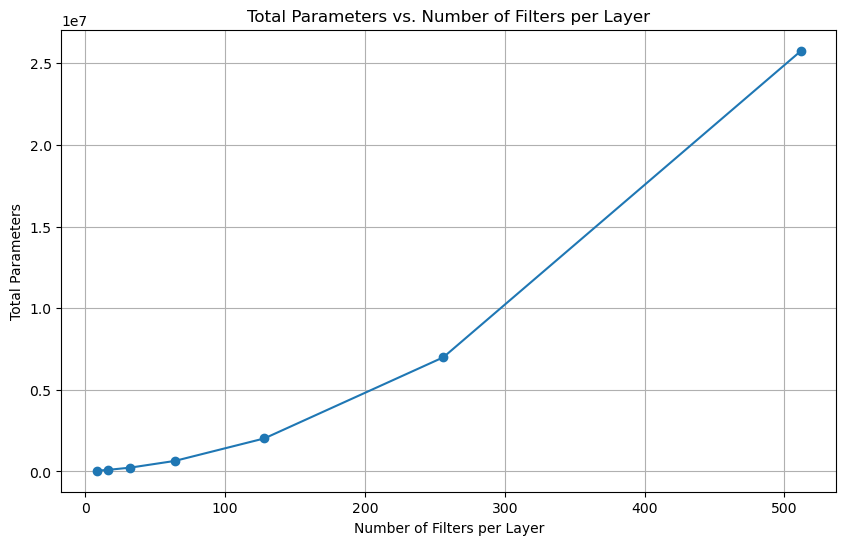

In [10]:
filter_counts = [8, 16, 32, 64, 128, 256, 512]
total_paramters = []

# Adjusted to use the filter pattern from the second chunk: size, size * 2, size * 4
for size in filter_counts:
    model = build_model(size, size * 2, size * 4) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    total_paramters.append(model.count_params())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(filter_counts, total_paramters, '-o')
plt.title('Total Parameters vs. Number of Filters per Layer')
plt.xlabel('Number of Filters per Layer')
plt.ylabel('Total Parameters')
plt.grid(True)
plt.show()


The graph shows a relatively smaller parameter increase from [32, 32] to [64, 64] filters. After that, the growth becomes significant, especially between [128, 128] and [256, 256], and pretty dramatic from [256, 256] to [512, 512].

This is because while convolutional layer parameters grow linearly with filters, the dense layers experience complex growth. Each new filter adds inputs to these layers. Notably, the final dense layer connected to all last convolutional maps sees a large non-linear, almost exponential parameter increase as feature maps rise.

<a id="q13"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>

<b>1.3 Choose a model, train and evaluate it</b>
<hr>    
<b>Q1.3.1</b>

<a id="q131"></a>

Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Report your validation and test accuracies. They should both exceed 70%.

**Hint:** It would be helpful to add code which either saves your model to a local directory if it is the first time you're training it or loads your model if a saved file version currently exists in that directory. This will not only help save time when you rerun your notebook, but it will also ensure reproducible results in the rest of Part 1.
</div>

In [11]:
# Function to build the model
def create_model():
    model = Sequential([
        # Convolutional layer block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
        
        # Convolutional layer block 2
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (1, 1), padding='same', activation='relu'), 
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Convolutional layer block 3
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Flatten the convolved images for the following dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
        
    return model

In [12]:

# Define a path to save the model
model_path = 'cifar10_model.h4_p1'

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 15, 15, 512)       0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 15, 15, 512)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 1024)      4719616   
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 6, 6, 1024)        0         
 ng2D)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 6, 6, 1024)       

In [13]:
# your code here 
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[checkpoint], verbose=1)

Epoch 1/10


2024-04-03 19:31:21.726727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-03 19:31:21.892007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-03 19:31:22.014529: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 19:31:22.330851: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 19:31:24.254637: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1cdca41c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 19:31:24.254683: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Comput

1250/1250 [==============================] - ETA: 0s - loss: 1.6965 - accuracy: 0.3727
Epoch 1: val_accuracy improved from -inf to 0.49920, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 89s 65ms/step - loss: 1.6965 - accuracy: 0.3727 - val_loss: 1.3852 - val_accuracy: 0.4992
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.3362 - accuracy: 0.5238
Epoch 2: val_accuracy improved from 0.49920 to 0.59390, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 1.3362 - accuracy: 0.5238 - val_loss: 1.1450 - val_accuracy: 0.5939
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 1.2106 - accuracy: 0.5705
Epoch 3: val_accuracy improved from 0.59390 to 0.63360, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 1.2106 - accuracy: 0.5705 - val_loss: 1.0376 - val_accuracy: 0.6336
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 1.1206 - accuracy: 0.6074
Epoch 4: val_accuracy improved from 0.63360 to 0.64970, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 1.1206 - accuracy: 0.6074 - val_loss: 1.0131 - val_accuracy: 0.6497
Epoch 5/10
1250/1250 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.6271
Epoch 5: val_accuracy improved from 0.64970 to 0.66590, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 1.0551 - accuracy: 0.6271 - val_loss: 0.9617 - val_accuracy: 0.6659
Epoch 6/10
1250/1250 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.6443
Epoch 6: val_accuracy improved from 0.66590 to 0.68220, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 1.0093 - accuracy: 0.6443 - val_loss: 0.9251 - val_accuracy: 0.6822
Epoch 7/10
1250/1250 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.6616
Epoch 7: val_accuracy improved from 0.68220 to 0.69690, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 0.9673 - accuracy: 0.6616 - val_loss: 0.8755 - val_accuracy: 0.6969
Epoch 8/10
1250/1250 [==============================] - ETA: 0s - loss: 0.9363 - accuracy: 0.6726
Epoch 8: val_accuracy improved from 0.69690 to 0.70840, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 0.9363 - accuracy: 0.6726 - val_loss: 0.8462 - val_accuracy: 0.7084
Epoch 9/10
1250/1250 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.6828
Epoch 9: val_accuracy did not improve from 0.70840
1250/1250 [==============================] - 76s 61ms/step - loss: 0.8984 - accuracy: 0.6828 - val_loss: 0.8425 - val_accuracy: 0.7060
Epoch 10/10
1250/1250 [==============================] - ETA: 0s - loss: 0.8671 - accuracy: 0.6972
Epoch 10: val_accuracy improved from 0.70840 to 0.72750, saving model to cifar10_model.h4_p1
INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


INFO:tensorflow:Assets written to: cifar10_model.h4_p1/assets


1250/1250 [==============================] - 81s 65ms/step - loss: 0.8671 - accuracy: 0.6972 - val_loss: 0.7917 - val_accuracy: 0.7275


In [14]:
# your code 
if os.path.exists(model_path):
    model = load_model(model_path)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 71.95%


In [15]:
# your code here
validation_accuracy = history.history['val_accuracy']
for i, acc in enumerate(validation_accuracy):
    print(f"Epoch {i+1}: Validation Accuracy = {acc * 100:.2f}%")

Epoch 1: Validation Accuracy = 49.92%
Epoch 2: Validation Accuracy = 59.39%
Epoch 3: Validation Accuracy = 63.36%
Epoch 4: Validation Accuracy = 64.97%
Epoch 5: Validation Accuracy = 66.59%
Epoch 6: Validation Accuracy = 68.22%
Epoch 7: Validation Accuracy = 69.69%
Epoch 8: Validation Accuracy = 70.84%
Epoch 9: Validation Accuracy = 70.60%
Epoch 10: Validation Accuracy = 72.75%


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3.2</b>

<a id="q132"></a> 

Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

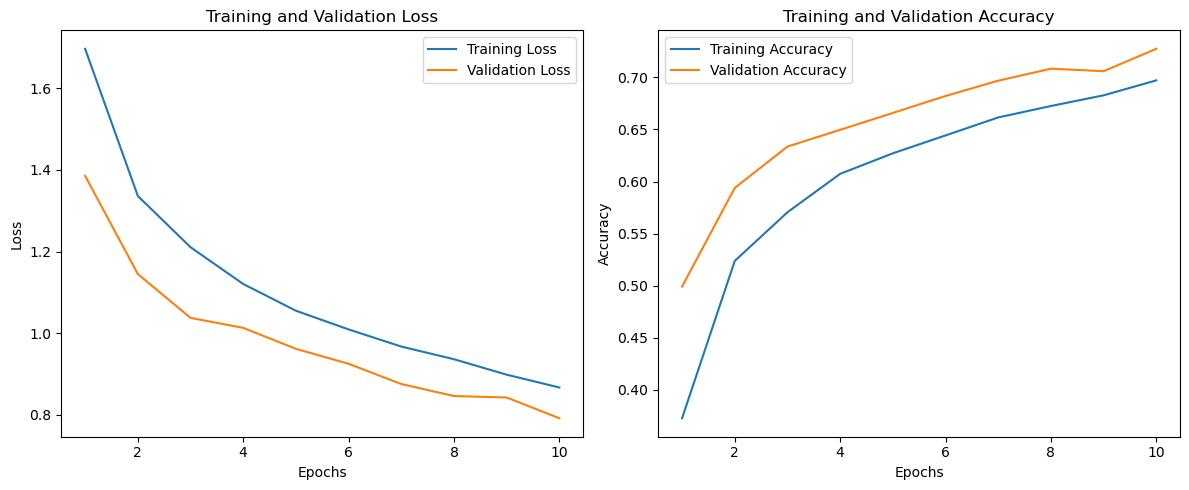

In [17]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Subplot for training and validation loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust the layout so that plots are neatly arranged
plt.tight_layout()

# Display the plot
plt.show()

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2: Regression with CNN 
<a id="part2intro"></a>
## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="q21"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.1 Data preparation</b>
<hr>
<b>Q2.1.1</b>

<a id="q211"></a>

Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 1.3GB, which can take 10-15 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and validation dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays? 
    
**Note:** You do not need to create a separate validation anywhere in Part 2. We are just using train and test with no validation for simplicity.
    </div>

In [18]:
# Run this cell to define our download_celeb function
def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.1.0")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            print(
                "...downloading"
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o\n"
            "".format(filename)
        )

        import tarfile
        with tarfile.open(filepath, "r:gz") as tar:
            tar.extractall(path=dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [19]:
%%time
# Download the CelebA dataset
url = "https://bit.ly/4a79WzJ"
filename = "2.1.0.tar.gz"
dirname = "data"
dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

# Running on JupyterHub with data
if os.path.isdir('/home/course_data/celeb_a/2.1.0/'):
    data_dir = '/home/course_data'
# Running anywhere else
else:
    data_dir = os.path.join(working_dir, "data")
    download_celeb(url, filename, filepath, dirname, dirpath)

CPU times: user 153 µs, sys: 85 µs, total: 238 µs
Wall time: 11.9 ms


In [20]:
# This will load the dataset
# Either the one hosted on Jupyter Hub or the copy you downloaded above
train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir = data_dir,
    download=False,
)

In [21]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [22]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.2</b>

<a id="q212"></a>

**Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

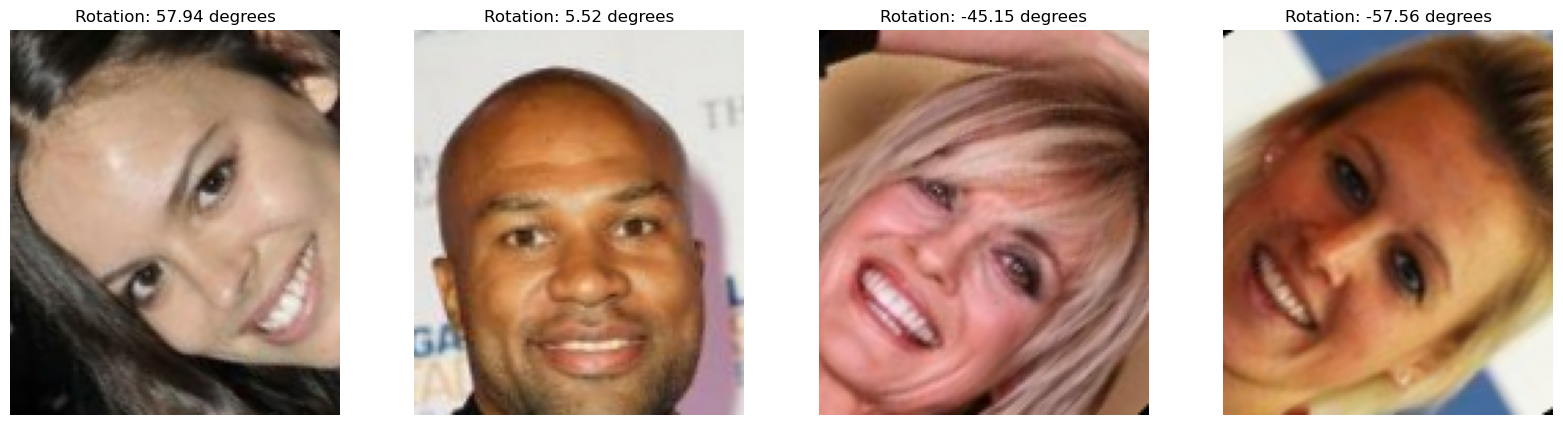

In [23]:
# your code here
# Take 4 samples from the dataset
samples = train_rot_ds.take(4)

# Set up the plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, (image, label) in zip(axes, samples):
    # Convert the image to numpy and scale it back to [0,255] for plotting
    image = image.numpy()
    image = (image * 255).astype('uint8')

    # Plot the image
    ax.imshow(image)
    # Set the title to the rotation angle, formatted to 2 decimal places
    ax.set_title(f"Rotation: {label.numpy():.2f} degrees")
    ax.axis('off')

plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.3</b>

<a id="q213"></a>

**2.1.3** **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

Using dropout can be really helpful for training deep neural nets to estimate image orientation. Dropout randomly "drops out" some neurons during training, preventing them from becoming too codependent. This forces the model to learn redundant, more robust representations that are less likely to overfit to the training data.

For a complex task like determining the orientation of face images, where there might be high correlations between pixels, dropout layers can improve generalization by making the model learn orientation-invariant features. But you have to be careful about the dropout rate and layers - too much dropout could cause underfitting, where the model doesn't learn the patterns well enough. Finding that sweet spot is key.

<a id="q22"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.2 Building and training your CNN</b>
<hr>
<a id="q221"></a>
<b>Q2.2.1 Compiling your model.</b>
    
Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. 
    
**Note:** Again, it is fine to attempt your own implementation of a well-known architecture, but you may not load any pre-constructed models. The network must be built layer-by-layer from your own code.
    </div>

In [24]:
# your code here
model = models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Layer 4
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening the 3D outputs to 1D and adding Dropout
    layers.Flatten(),
    layers.Dropout(0.5),
    
    # Dense Layer
    layers.Dense(512, activation='relu'),
    
    # Output Layer - Predicting the rotation angle
    layers.Dense(1)
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 138, 118, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 69, 59, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 67, 57, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 33, 28, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 31, 26, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 15, 13, 128)      

In [25]:
# your code here
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.2 Training your model</b>

<a id="q222"></a>

Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.
    </div>

In [26]:
# your code here
BATCH_SIZE = 32

# Prepare the training dataset
train_ds = train_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare the validation dataset
val_ds = test_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds
)

# Evaluate the model performance
test_loss, test_mae = model.evaluate(val_ds)
print(f"Test MSE: {test_loss}, Test MAE: {test_mae}")

Epoch 1/3
5087/5087 [==============================] - 520s 102ms/step - loss: 45.3439 - mean_absolute_error: 4.2405 - val_loss: 12.7623 - val_mean_absolute_error: 2.4148
Epoch 2/3
5087/5087 [==============================] - 519s 102ms/step - loss: 15.5211 - mean_absolute_error: 2.7153 - val_loss: 7.9940 - val_mean_absolute_error: 1.8096
Epoch 3/3
624/624 [==============================] - 55s 88ms/step - loss: 8.4797 - mean_absolute_error: 1.9655
Test MSE: 8.479679107666016, Test MAE: 1.9654697179794312


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.3 Saving and loading your weights</b>

<a id="q223"></a>

Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?
    
**Note:** Please do *not* upload your model weights with your notebook submission.
    </div>

Saving only the weights after training and loading them again allows us to modify the model's architecture, but we must have the code for the architecture defined. This lets us resume training from where it was left off. Alternatively, saving the full model is more convenient and flexible as it includes the architecture, weights, training configuration, and optimizer state, allowing us to resume training seamlessly without needing to redefine the model.

In [27]:
# your code here
# Save the model weights
model.save_weights('model/testing_save_weights')

In [28]:
# your code here
model.load_weights('model/testing_save_weights')

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.4 Evaluating your model</b>

<a id="q224"></a>

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)
    
**Hint:** Your network expects its input to have an explicit 'batch' dimension (the 1st dimension). If you use `take()` to get one image from your dataset, you will need to add this extra batch dimension to it in order to pass it to `predict()`. There are several ways to do this. You can check out [this SO post](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) for some ideas.

1/1 [==============================] - 0s 20ms/step


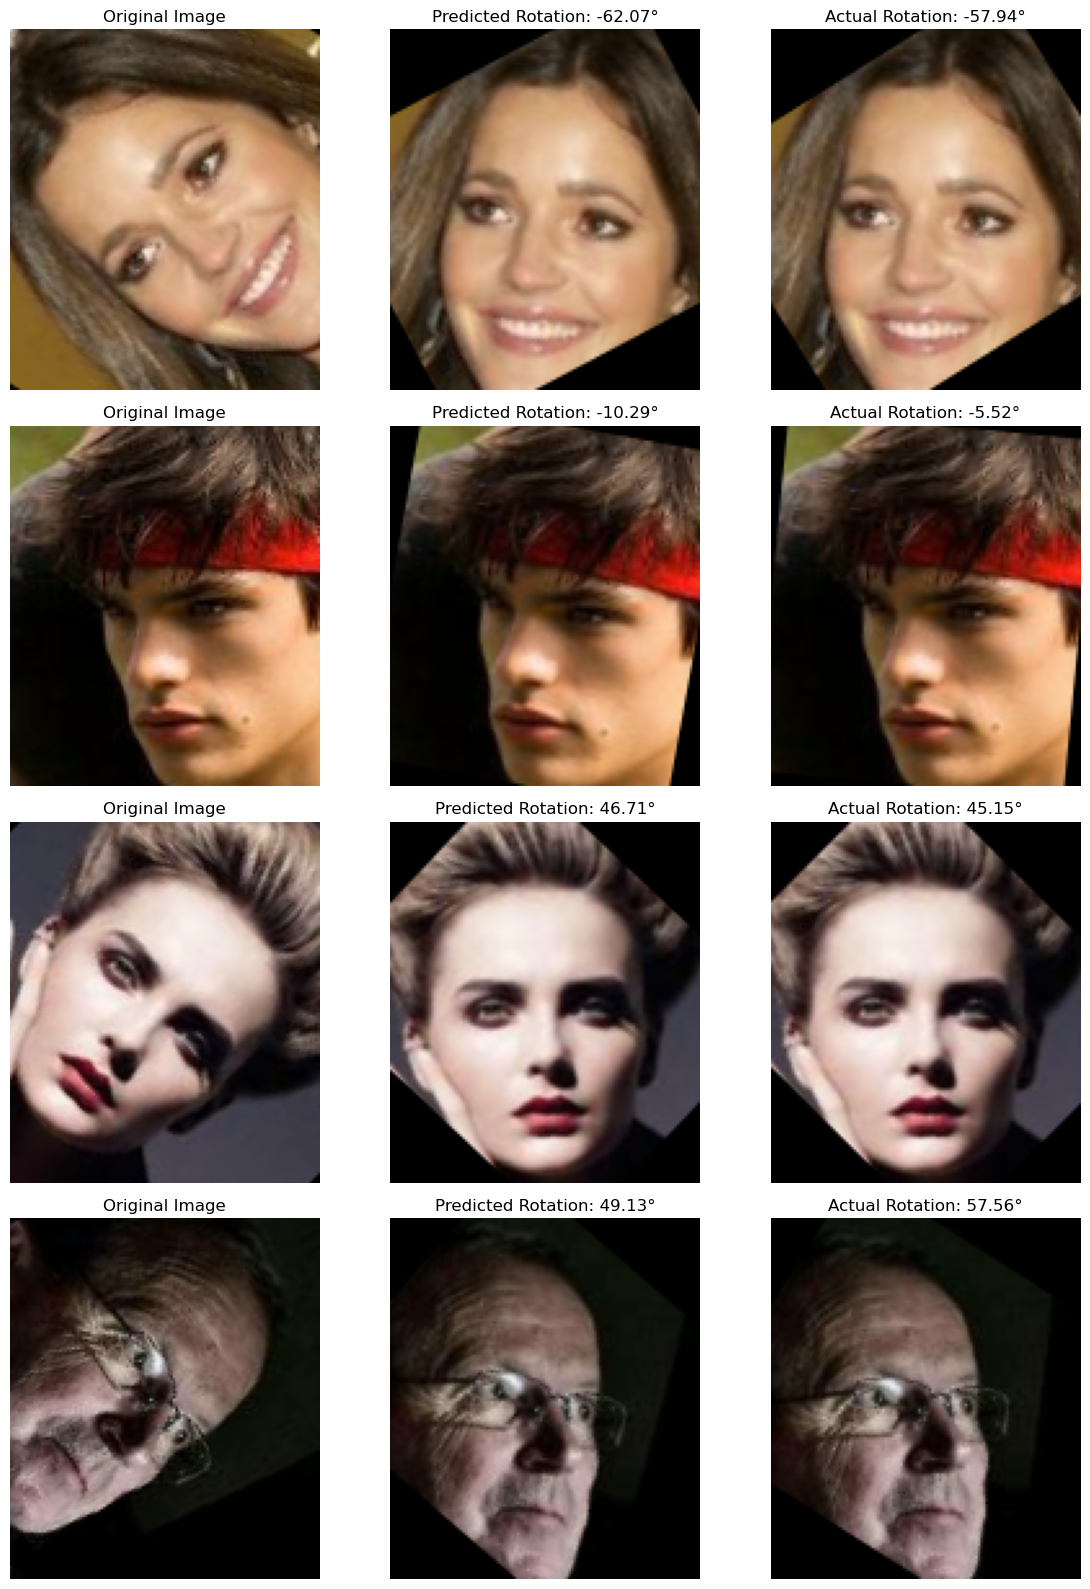

In [29]:
# your code here
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# Take 4 samples from the test dataset
for i, (image, label) in enumerate(test_rot_ds.take(4)):
    image_np = image.numpy()
    label_np = label.numpy()
    
    # Predict rotation
    pred_rotation = model.predict(tf.expand_dims(image, 0))
    
    # Straighten image based on predicted and actual rotation
    pred_straightened = tf_rot_resize(image_np, -pred_rotation[0][0])
    target_straightened = tf_rot_resize(image_np, -label_np)
    
    # Plot Original Image
    axs[i, 0].imshow(image_np)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')
    
    # Plot Predicted Straightened Image
    axs[i, 1].imshow(pred_straightened)
    axs[i, 1].set_title(f'Predicted Rotation: {-pred_rotation[0][0]:.2f}°')
    axs[i, 1].axis('off')
    
    # Plot Target Straightened Image
    axs[i, 2].imshow(target_straightened)
    axs[i, 2].set_title(f'Actual Rotation: {-label_np:.2f}°')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'>
<a id="q23"></a>
<b>2.3 Further Analysis</b>
<hr>
<b>Q2.3.1 Correct an image of your choosing</b>

<a id="q231"></a>

Find an image or image(s) (not from the provided test/training sets), or make your own; it does not necessarily have to be a human face. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)
    
**Note:** Please do *not* upload your custom image as a separate file with your notebook submission. It is sufficient to display your results in the cell output.
    </div>

1/1 [==============================] - 0s 23ms/step


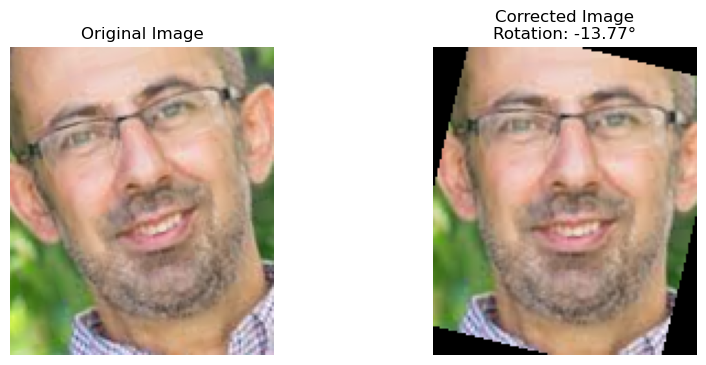

In [30]:
# your code here
image_path = 'download.jpeg'
img = tf.io.read_file(image_path)
img = tf.io.decode_image(img, channels=3)

img_normalized = normalize_image(img)
deg = 17.2
image = rot_resize(img_normalized, deg)

image_batch = np.expand_dims(image, axis=0)  # Add batch dimension


predicted_rotation = model.predict(image_batch)

corrected_image = rot_resize(image, -predicted_rotation[0][0])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(corrected_image, vmin=0, vmax=1)
plt.title(f"Corrected Image\nRotation: {-predicted_rotation[0][0]:.2f}°")
plt.axis("off")

plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Wrap-up</b>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.
    </div>

Using GPUs significantly improved the time it took to run the training of the models. However, we felt a bit rushed on this home work since we waited to start on it after the CNN lab was done effectively giving us less than a week to complete it. We however still found it to be manageable. 

In [31]:
hours_spent_on_hw = 6

In [32]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [33]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 42.15 minutes for this notebook to run


**This concludes HW4. Thank you!**